# Comparing Impacts of Missing Data on Uniform and Lognormal Regressors

In [30]:
from generator import *
from shredder import *
from fitter import *
from fixer import *
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
#np.random.seed(10)



# Generating regression data


In [70]:
# Declare that there should be one X uniformly distributed between 0 and 100 with a coefficient of 5.


x1_norm_clean_fit_data, x1_norm_test_data, x1_norm_coeffs = generate_ind_model(
                                                        1, 
                                                        [x_def_helper('lognormal', coeff=6, mean=1, sigma=1)],
                                                        intercept=10, 
                                                        n=16, 
                                                        beta_sigma=.01
                                                    )

x1_uniform_clean_fit_data, x1_uniform_test_data, x1_uniform_coeffs = generate_ind_model(
                                                        1, 
                                                        [x_def_helper('uniform', coeff=10, low=0, high=1)],
                                                        intercept=10,
                                                        n=100, 
                                                        beta_sigma=.5
                                                    )
print(x1_norm_clean_fit_data['y'].std())
print(x1_uniform_clean_fit_data['y'].std())



66.06366815919948
5.882370335818625


### Initial EDA/Modeling

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b3e0780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11b5fb128>]], dtype=object)

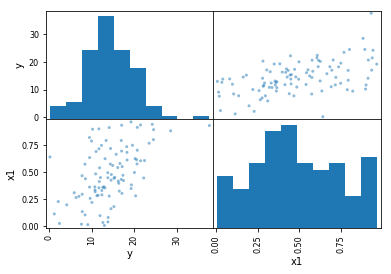

In [71]:
scatter_matrix(x1_uniform_clean_fit_data[['y', 'x1']])

### Part 1: Randomly Removing Values of `x1` and Dropping Respective Rows 
This is now performed for both the uniform and lognormal case

In [55]:
def run(fit_data, test_data, action_type, incr=.05,iters=50):
    run_results = []
    # Begin replication loop
    for i in range(iters):
        # Begin percent range loop
        for pct in np.arange(0, .8, incr):

            # Make a copy of the dataset so that we do not contaminate the memory
            wrecked_data = fit_data.copy(deep=True)
            
            # Shred the data unless pct == 0
            if pct != 0:
                # Specify that we are shredding x1
                uniform_shred_cols(['x1'], pct, wrecked_data)

                if action_type == 'drop':
                    fixed_data = wrecked_data.dropna()
                elif action_type == 'fix':
                    fixed_data = fix_cols({'x1': 'mean'}, wrecked_data)
                else:
                    raise ValueError("Invalid action_type: %s" % action_type)
            else:
                fixed_data = wrecked_data
                    
            # Fit the model
            w_fitted, w_metrics, = fit_lm(fixed_data, test_data)
            
            # Check if beta estimates are in the CI
            b_estimate_results = beta_target_check(w_metrics, x1_uniform_coeffs, as_dataframe=True)

            # Collect some results
            run_results.append((pct,
                                  w_fitted.nobs,
                                  w_metrics['r2'],
                                  w_metrics['r2_adj'],
                                  w_metrics['bic'],
                                  w_metrics['beta_ci']['x1']['range'],
                                  b_estimate_results.loc['x1', :].values[0],
                                  w_metrics['r2_pred'],
                                  w_metrics['mse_pred']))


    # Load the results into a Pandas Dataframe
    results = pd.DataFrame(run_results, columns=['pct_missing', 
                                                      'nobs', 
                                                      'r2', 
                                                      'r2_adj',
                                                      'bic', 
                                                      'beta_x1_rng',
                                                      'beta_x1_target',
                                                      'r2_pred', 
                                                      'mse'])
    results_agg = results.copy()
    results_agg = results_agg.groupby('pct_missing').mean()
    results_agg.loc[:, 'action_type'] = action_type
    
    return results_agg, results


def run_new(fit_data, test_data, action_type, incr=.05,iters=50):
    run_results = []
    # Begin replication loop
    for i in range(iters):
        # Begin percent range loop
        for pct in np.arange(0, .7, incr):

            # Make a copy of the dataset so that we do not contaminate the memory
            wrecked_data = fit_data.copy(deep=True)
            
            # Shred the data unless pct == 0
            if pct != 0:
                # Specify that we are shredding x1
                uniform_shred_cols(['x1'], pct, wrecked_data)

                if action_type == 'drop':
                    fixed_data = wrecked_data.dropna()
                elif action_type == 'mean':
                    fixed_data = fix_cols({'x1': 'mean'}, wrecked_data)
                elif action_type == 'invert':
                    fixed_data, w_impute_coeff = inverse_fit_impute('x1', 'y', wrecked_data)
                elif action_type == 'random':
                    fixed_data = rand_replace('x1', wrecked_data)
                else:
                    raise ValueError("Invalid action_type: %s" % action_type)
            else:
                fixed_data = wrecked_data
                    
            # Fit the model
            w_fitted, w_metrics, = fit_lm(fixed_data, test_data)
            
            # Check if beta estimates are in the CI
            b_estimate_results = beta_target_check(w_metrics, x1_uniform_coeffs, as_dataframe=True)

            # Collect some results
            run_results.append((pct,
                                  w_fitted.nobs,
                                  w_metrics['r2'],
                                  w_metrics['r2_adj'],
                                  w_metrics['bic'],
                                  w_metrics['beta_ci']['x1']['range'],
                                  b_estimate_results.loc['x1', :].values[0],
                                  w_fitted.params['x1'],
                                  w_metrics['r2_pred'],
                                  w_metrics['mse_pred']))


    # Load the results into a Pandas Dataframe
    results = pd.DataFrame(run_results, columns=
                           ['pct_missing', 
                            'nobs', 
                            'r2', 
                            'r2_adj',
                            'bic', 
                            'beta_x1_rng',
                            'beta_x1_target',
                            'beta_x1',
                            'r2_pred', 
                            'mse'])
    
    results_agg = results.copy()
    results_agg = results_agg.groupby('pct_missing').mean()
    results_agg.loc[:, 'action_type'] = action_type
    
    return results_agg, results



In [56]:

x1_uniform_results_mean_agg, x1_uniform_mean_results = run_new(x1_uniform_clean_fit_data, 
                                                         x1_uniform_test_data, 
                                                         'mean', 
                                                         iters=300)

x1_uniform_results_invert_agg, x1_uniform_invert_results = run_new(x1_uniform_clean_fit_data, 
                                                                   x1_uniform_test_data, 
                                                                   'invert', 
                                                                   iters=300)

x1_uniform_results_drop_agg, x1_uniform_drop_results = run_new(x1_uniform_clean_fit_data, 
                                                               x1_uniform_test_data, 
                                                               'drop', 
                                                               iters=300)

# x1_uniform_results_rand_agg, x1_uniform_rand_results = run_new(x1_uniform_clean_fit_data, 
#                                                                x1_uniform_test_data, 
#                                                                'random', 
#                                                                iters=100)


                      

In [57]:
x1_uniform_results = {'mean_replace': x1_uniform_results_mean_agg,
                      'invert': x1_uniform_results_invert_agg,
                      'drop': x1_uniform_results_drop_agg,
                      'rand': x1_uniform_results_rand_agg}


In [58]:
x1_uniform_results_invert_agg
#print(x1_lognorm_results_agg['fix'][['beta_x1_target']])|

,nobs,r2,r2_adj,bic,beta_x1_rng,beta_x1_target,beta_x1,r2_pred,mse,action_type
pct_missing,,,,,,,,,,
0.00,100.0,0.754002,0.751492,372.718665,2.191433,1.000000,9.569474,0.780322,2.530016,invert
0.05,100.0,0.766520,0.764138,367.445992,2.119233,1.000000,9.577544,0.780243,2.530933,invert
0.10,100.0,0.779445,0.777195,361.705606,2.043147,0.990000,9.579252,0.779962,2.534171,invert
0.15,100.0,0.791668,0.789542,355.928539,1.970113,0.946667,9.578199,0.779435,2.540234,invert
0.20,100.0,0.804472,0.802477,349.506833,1.886895,0.906667,9.545499,0.778758,2.548033,invert
0.25,100.0,0.816942,0.815074,342.816897,1.811060,0.860000,9.542811,0.778201,2.554454,invert
0.30,100.0,0.828342,0.826590,336.194902,1.747473,0.836667,9.574766,0.778165,2.554864,invert
0.35,100.0,0.842747,0.841143,327.409591,1.651173,0.750000,9.535015,0.777356,2.564176,invert
0.40,100.0,0.854526,0.853042,319.602074,1.583451,0.743333,9.574684,0.777191,2.566084,invert


Text(0.5,0,'% missing')

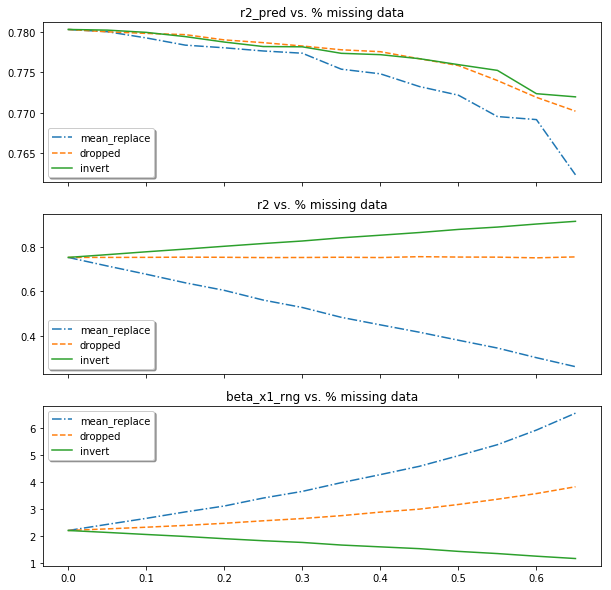

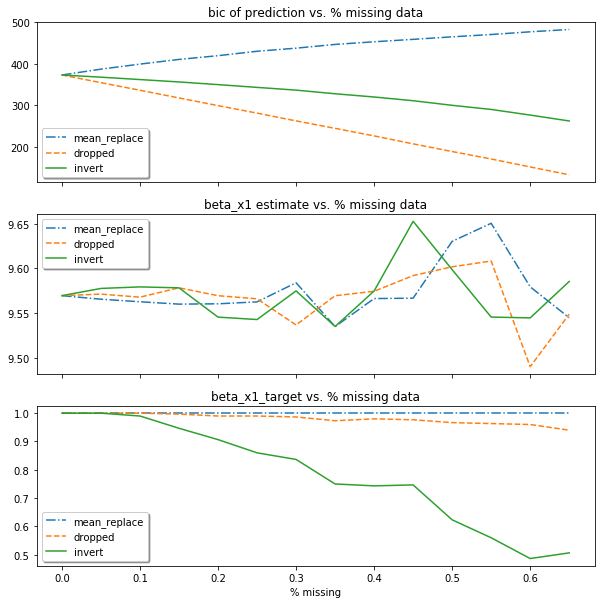

In [59]:
x1_uniform_results = x1_uniform_results
f, axarr = plt.subplots(3, sharex=True, figsize=(10,10))
axarr[0].plot(x1_uniform_results['mean_replace'][['r2_pred']], label='mean_replace', linestyle='-.')
axarr[0].plot(x1_uniform_results['drop'][['r2_pred']], label='dropped', linestyle='--')
axarr[0].plot(x1_uniform_results['invert'][['r2_pred']], label='invert')
#axarr[0].plot(x1_uniform_results['rand'][['r2_pred']], label='rand')
axarr[0].set_title('r2_pred vs. % missing data')
axarr[0].legend(shadow=True, fancybox=True)

axarr[1].plot(x1_uniform_results['mean_replace'][['r2']], label='mean_replace', linestyle='-.')
axarr[1].plot(x1_uniform_results['drop'][['r2']], label='dropped', linestyle='--')
axarr[1].plot(x1_uniform_results['invert'][['r2']], label='invert')
#axarr[1].plot(x1_uniform_results['rand'][['r2']], label='rand')
axarr[1].set_title('r2 vs. % missing data')
axarr[1].legend(shadow=True, fancybox=True)


axarr[2].plot(x1_uniform_results['mean_replace'][['beta_x1_rng']], label='mean_replace', linestyle='-.')
axarr[2].plot(x1_uniform_results['drop'][['beta_x1_rng']], label='dropped', linestyle='--')
axarr[2].plot(x1_uniform_results['invert'][['beta_x1_rng']], label='invert')
#axarr[2].plot(x1_uniform_results['rand'][['beta_x1_rng']], label='rand')
axarr[2].set_title('beta_x1_rng vs. % missing data')
axarr[2].legend(shadow=True, fancybox=True)

f, axarr = plt.subplots(3, sharex=True, figsize=(10,10))
axarr[0].plot(x1_uniform_results['mean_replace'][['bic']], label='mean_replace', linestyle='-.')
axarr[0].plot(x1_uniform_results['drop'][['bic']], label='dropped', linestyle='--')
axarr[0].plot(x1_uniform_results['invert'][['bic']], label='invert')
#axarr[3].plot(x1_uniform_results['rand'][['bic']], label='rand')
axarr[0].set_title('bic of prediction vs. % missing data')
axarr[0].legend(shadow=True, fancybox=True)

#beta_x1
axarr[1].plot(x1_uniform_results['mean_replace'][['beta_x1']], label='mean_replace', linestyle='-.')
axarr[1].plot(x1_uniform_results['drop'][['beta_x1']], label='dropped', linestyle='--')
axarr[1].plot(x1_uniform_results['invert'][['beta_x1']], label='invert')
#axarr[4].plot(x1_uniform_results['rand'][['beta_x1']], label='rand')
axarr[1].set_title('beta_x1 estimate vs. % missing data')
axarr[1].legend(shadow=True, fancybox=True)

#beta_x1_target
axarr[2].plot(x1_uniform_results['mean_replace'][['beta_x1_target']], label='mean_replace', linestyle='-.')
axarr[2].plot(x1_uniform_results['drop'][['beta_x1_target']], label='dropped', linestyle='--')
axarr[2].plot(x1_uniform_results['invert'][['beta_x1_target']], label='invert')
#axarr[5].plot(x1_uniform_results['rand'][['beta_x1_target']], label='rand')
axarr[2].set_title('beta_x1_target vs. % missing data')
axarr[2].legend(shadow=True, fancybox=True)

axarr[2].set_xlabel('% missing')
#plt.legend(shadow=True, fancybox=True)




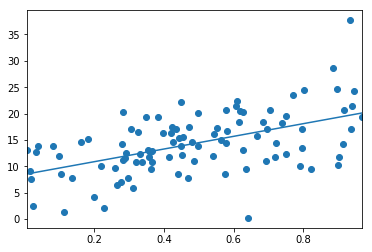

In [76]:
wrecked_data = x1_uniform_clean_fit_data.copy(deep=True)
#wrecked_data = uniform_shred_cols(['x1'], .5, wrecked_data)

#fixed_data, w_impute_coeff = inverse_fit_impute('x1', 'y', wrecked_data)
#fixed_data = fix_cols({'x1': 'mean'}, wrecked_data)
ex_fitted, ex_metrics, = fit_lm(wrecked_data, x1_uniform_test_data)


fig = sm.graphics.abline_plot(model_results=ex_fitted)
ax = fig.axes[0]
ax.scatter(wrecked_data['x1'], wrecked_data['y'])


In [77]:
print(ex_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     37.31
Date:                Mon, 19 Feb 2018   Prob (F-statistic):           2.04e-08
Time:                        14:13:47   Log-Likelihood:                -302.46
No. Observations:                 100   AIC:                             608.9
Df Residuals:                      98   BIC:                             614.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4609      1.081      7.826      0.0

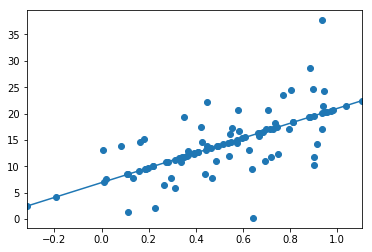

In [75]:
wrecked_data = x1_uniform_clean_fit_data.copy(deep=True)
wrecked_data = uniform_shred_cols(['x1'], .5, wrecked_data)

fixed_data, w_impute_coeff = inverse_fit_impute('x1', 'y', wrecked_data)
#fixed_data = fix_cols({'x1': 'mean'}, wrecked_data)
ex_fitted, ex_metrics, = fit_lm(fixed_data, x1_uniform_test_data)


fig = sm.graphics.abline_plot(model_results=ex_fitted)
ax = fig.axes[0]
ax.scatter(fixed_data['x1'], fixed_data['y'])